In [4]:
from scipy.special import hermite
from scipy.integrate import quad
from numpy import pi, sqrt, exp, conj, real, imag, sin, cos, dot
from math import factorial, gamma
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# %matplotlib qt

Полиномы Эрмита
$$
    H_n(x)= e^{x^2/2} \left(\frac{d}{dx} - x\right)^n e^{-x^2/2}
$$
Функции Эрмита
$$
    \mathcal H_n(x) = \frac{1}{\pi^{1/4} 2^{n/2} \sqrt{n!}} H_n(x) \, e^{-x^2/2}
$$
Нормировка функций Эрмита
$$
    (\mathcal H_n, \mathcal H_m) = \int_{-\infty}^{\infty} dx \, \mathcal H_n(x)\, \mathcal H_m(x) = \delta_{nm}
$$

In [5]:
def herm_n(k):
    '''Возвращает нормированный полином Эрмита.
    '''
    return hermite(k) / (2**(k/2) * pi**(1/4) * sqrt(gamma(k+1)))

def herm_f(k, x):
    '''Возвращает нормированную функцию Эрмита.
    '''
    return herm_n(k)(x) * exp(-x**2 / 2)

По функциям Эрмита можно разложить произвольную функцию $f(x)$, достаточно быстро затухающую на бесконечности
$$
    f_n = (\mathcal H_n, f) = \int_{-\infty}^{\infty} dx \, \mathcal H_n(x)\, f(x)
$$
$$
    f(x) = \sum_{n=0}^\infty f_n \, \mathcal H_n(x)
$$
Функции Эрмита $\mathcal H_n(x)$ имеют осциллирующее поведение при $|x| < x_n \equiv \sqrt{2n+1}$ и экспоненциально затухают при $|x| > x_n$
$$
    \mathcal H_n(x) \sim \exp\left(-\frac23 \left(2^{1/2} n^{1/6} ||x| - x_n|\right)^{3/2}\right), \quad n > 0.
$$
Зная это поведение можно задать интервал интегрирования согласно требуемой точности.

In [33]:
C = 10      #задаёт точность

def proj(k, f):
    '''Возвращает проекцию функции f на k-ую функцию Эрмита
    '''
    x_lim = 0
    if k:
        x_lim = sqrt(2*k + 1) + (C)**(2/3) * k**(-1/6) 
    else:
        x_lim = sqrt(3 * C)
    ans = quad(lambda x: real(herm_f(k, x) * f(x)), -x_lim, x_lim)[0]
    ans += 1.j * quad(lambda x: imag(herm_f(k, x) * f(x)), -x_lim, x_lim)[0]
    return ans

Взятие производной и умножение функции Эрмита на $x$ снова выражается через функции Эрмита
\begin{align}
    \frac{d}{dx} \mathcal H_n(x) &= \sqrt{\frac{n}{2}} \mathcal H_{n-1}(x) - \sqrt{\frac{n+1}{2}} \mathcal H_{n+1}(x)\\
    x \mathcal H_n(x) &= \sqrt{\frac{n}{2}} \mathcal H_{n-1}(x) + \sqrt{\frac{n+1}{2}} \mathcal H_{n+1}(x)
\end{align}

In [53]:
class HermiteF():
    '''Класс, содержащий в себе представление некоторой функции в виде ряда по функциям Эрмита.
    '''
    def __init__(self, source, **kwargs):
        if callable(source):
            coefs = []
            for k in range(kwargs['N']):
                coefs.append(proj(k, source))
            self.coefs = np.array(coefs)
        elif hasattr(source, '__iter__'):
            self.coefs = np.array(source)
        
    def __mul__(self, inst):
        '''Умножение на число или на линейную комбинацию функций Эрмита. 
        '''
        if isinstance(inst, HermiteF):
            min_l = min(len(self.coefs), len(inst.coefs))
            return dot(conj(self.coefs[:min_l]), inst.coefs[:min_l]).sum()
        elif isinstance(inst, (float, complex, int)):
            return HermiteF(inst * self.coefs)
        
    def __rmul__(self, inst):
        '''Правое умножение на число. 
        '''
        if isinstance(inst, (float, complex, int)):
            return HermiteF(inst * self.coefs)
        
    def __truediv__(self, inst):
        if isinstance(inst, (float, complex, int)):
            return HermiteF(inst**(-1) * self.coefs)
        
    def normalize(self):
        '''Нормировка на единицу.
        '''
        norm = sqrt(self * self)
        self.coefs = self.coefs / norm
        
    def __call__(self, arg):
        return sum([coef * herm_f(k, arg) for k, coef in enumerate(self.coefs)])
    
    def __str__(self):
        return str(self.coefs)
    
    def mul_x(self, k=1):
        '''Умножение на x^k.
        '''
        if k == 1:
            l = self.coefs.shape[0]
            new_c = np.zeros((l + 1,), dtype=self.coefs.dtype)
            m = np.array(range(l+1))
            new_c[1:] += sqrt(m[1:]/2) * self.coefs
            new_c[:-2] += sqrt(m[1:-1]/2) * self.coefs[1:]
            self.coefs = new_c
        else:
            self.mul_x()
            self.mul_x(k-1)
        
    def der_x(self, k=1):
        '''k-ая производная по x.
        '''
        if k == 1:
            l = self.coefs.shape[0]
            new_c = np.zeros((l + 1,), dtype=self.coefs.dtype)
            m = np.array(range(l+1))
            new_c[1:] -= sqrt(m[1:]/2) * self.coefs
            new_c[:-2] += sqrt(m[1:-1]/2) * self.coefs[1:]
            self.coefs = new_c
        else:
            self.der_x()
            self.der_x(k-1)
        
    def __repr__(self):
        return "HermiteF([" + ", ".join(map(str, self.coefs.tolist())) + "])"

Уравнение Шрёдингера для осциллятора
$$
    i \hbar \partial_t \psi(t, x) = \left(-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + \frac{m \omega x^2}{2}\right) \psi(t, x)
$$
Если время и координаты выразить в единицах
$$
    x_0 = \sqrt{\frac{\hbar}{m\omega}}, \qquad t_0 = \frac{2\pi}{\omega},
$$
оно примет вид
$$
    i \partial_t \psi(t, x) = \pi \left(-\frac{\partial^2}{\partial x^2} + x^2\right) \psi(t, x).
$$
Решениями стационарного уравнения Шрёдингера
$$
    \pi \left(-\frac{\partial^2}{\partial x^2} + x^2\right) \psi(x) = E \, \psi(x).
$$
являются функции Эрмита
$$
    \pi \left(-\frac{\partial^2}{\partial x^2} + x^2\right) \mathcal H_n(x) = E_n \, \mathcal H_n(x), \quad E_n = 2\pi \, (n + \tfrac12).
$$
Тогда $\mathcal H_n(x) \, e^{-iE_n t}$ решают нестационарное уравнение Шрёдингера, и проивольное решение имеет вид
$$
    \psi(t, x) = \sum_{n=0}^\infty \psi_n \, \mathcal H_n(x) \, e^{-2\pi i (n + \frac12)t},
$$
где $\psi_n$ определяются начальным профилем волновой функции $\psi(x)$ в момент $t=0$
$$
    \psi_n = (\mathcal H_n, \psi) = \int_{-\infty}^{\infty} dx \, \mathcal H_n(x)\, \psi(x)
$$

In [54]:
class Oscillator(HermiteF):
    def __init__(self, source, **kwargs):
        super().__init__(source, **kwargs)
        self.normalize()
        
    def evolve(self, t):
        '''Эволюционирует вектор состояния на время t.
        '''
        k = np.arange(self.coefs.shape[0])
        self.coefs = self.coefs * exp(-2.j * pi * (k + 0.5) * t)
        
    def __call__(self, x, t=0, rtype='ampl'):
        ans = sum([coef * herm_f(k, x) * exp(-2.j*pi*(k+0.5)*t)
                        for k, coef in enumerate(self.coefs)])
        if rtype == 'ampl':
            return ans
        elif rtype == 'prob':
            return abs(ans)**2
        
    def coord(self, t=0, k=1):
        '''Возвращает среднее от x^k в момент времени t.
        '''
        h = Oscillator(self.coefs)
        g = Oscillator(self.coefs)
        h.evolve(t)
        g.evolve(t)
        h.mul_x(k)
        return real(g * h)
    
    def momentum(self, t=0, k=1):
        '''Возвращает среднее от p^k в момент времени t.
        '''
        h = Oscillator(self.coefs)
        g = Oscillator(self.coefs)
        h.evolve(t)
        g.evolve(t)
        h.der_x(k)
        h = h * (-1.j)**k
        return real(g * h)

In [55]:
# Когерентное состояние
a = (1 + 1.j) / sqrt(2)
osc = Oscillator([a**k / sqrt(gamma(k+1)) for k in range(20)])

In [59]:
xi = 2
init = lambda x: exp(-((x - 1)**2 - 2.j*xi*1*x)/(2*xi))
osc = Oscillator(init, N=10)
print(osc * osc)

(1+0j)


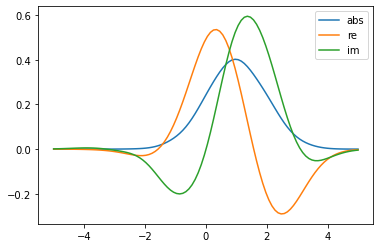

In [60]:
l_x = np.linspace(-5, 5, 100)
plt.plot(l_x, [osc(x, 0, 'prob') for x in l_x], label="abs")
plt.plot(l_x, [real(osc(x, 0, 'ampl')) for x in l_x], label="re")
plt.plot(l_x, [imag(osc(x, 0, 'ampl')) for x in l_x], label="im")
plt.legend()
plt.show()

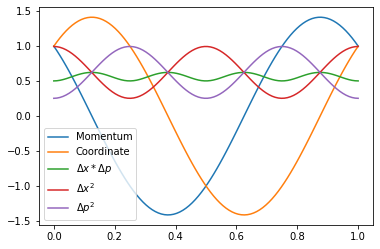

In [62]:
ls = np.linspace(0, 1, 100)
pp = np.array([osc.momentum(t, k=1) for t in ls])
xx = np.array([osc.coord(t, k=1) for t in ls])
dx2 = np.array([osc.coord(t, k=2) for t in ls])
dp2 = np.array([osc.momentum(t, k=2) for t in ls])
plt.plot(ls, pp, label="Momentum")
plt.plot(ls, xx, label="Coordinate")
plt.plot(ls, sqrt((dx2 - xx**2) * (dp2 - pp**2)), label="$\Delta x * \Delta p$")
plt.plot(ls, dx2 - xx**2, label="$\Delta x^2$")
plt.plot(ls, dp2 - pp**2, label="$\Delta p^2$")
plt.legend()
plt.show()

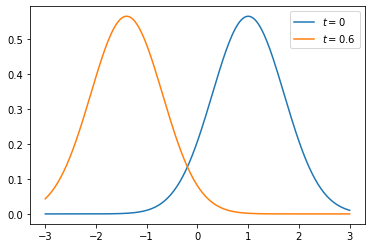

In [41]:
l_x = np.linspace(-3, 3, 200)
plt.plot(l_x, [osc(x, 0, 'prob') for x in l_x], label="$t = 0$")
plt.plot(l_x, [osc(x, 0.6, 'prob') for x in l_x], label="$t = 0.6$")
plt.legend()
plt.show()

Задание:
1. Найти волновую функцию локализованной частицы с ненулевым начальным импульсом.
2. Найти срекнеквадратичное отклонение координаты и импульса относительно среднего значения в зависимости от времени.
3. Найти зависимость этих среднеквадратичных отклонений от степени локализованности (характерной ширины графика волновой функции в начальный момент)

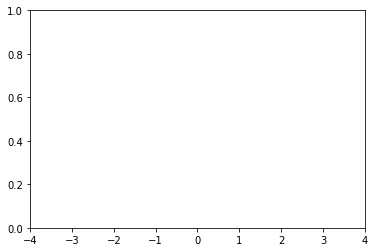

In [10]:
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [])
xdata = np.linspace(-4, 4, 200)

def init():
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, 1)
    return ln,

def update(frame):
    ydata = [osc(x, frame, 'prob') for x in xdata]
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 1, 128),
                    init_func=init, blit=True)
plt.show()

ani.save("coherent.gif", writer="imagemagick")